# Introduction

In the previous tutorial, we used Probability Density Approximation (PDA) to approximate the likelihood function of a choice probability retrieval model. In this tutorial, we will use PDA for a joint choice-rt model. This involves three steps: (1) simulate the model many times, (2) approximate the density for each choice with a kernel density function, and (3) weight each density function by the probability of the response. The follow sections review the Simple RT Model 2. You may skip over these details if you remember the details of the model. 

## Task

The task builds upon the task introduced in the tutorial for the Simple RT Model 1. Participants are asked a series of questions and must indicate by key press whether they know the correct answer or not. Lastly, when retrieval failures occur, the participants responds "I don't know" with the appropriate key. Such responses are considered incorrect. 

# Simple RT Model 2

On each trial, the Simple RT Model 2 encodes the stimulus and attempts to retrieve the answer. We assume that memories are highly distinguishable and have identical and stable activation, with the exception of transient noise. If a chunk is retrieved, the model responds "Yes". If the model fails to retrieve a chunk, it responds with the key corresponding to "I don't know".   

## Declarative memory

Let $M$ denote the set of  $n_{\rm items}$ chunks in declarative memory, where  $n_{\rm items}$ represents the number of stimuli used in the experiment. Each chunk consists of the following set of slots: $Q= \rm \{cue,value\}$. 

### Encoding

On each trial, a cue $v$ is presented on a screen and the model encodes the stimulus into a chunk that is stored in the imaginal buffer. Formally, we define the encoded chunk as:

\begin{align}
\mathbf{c}_{s,\textrm{imaginal}} = \{ (\rm cue, v)\}
\end{align}


### Retrieval Request

The retrieval request is defined as:

\begin{align}
\mathbf{r} = \{(\textrm{cue},c_{s,\rm imaginal}(\rm cue)\} 
\end{align}

where $c_{s,\rm imaginal}(\rm cue)$ is the cue value of the chunk in the imaginal buffer. The slot set for the retrieval request is defined as $Q_r = \rm \{cue\}$ 

### Response Set

In what follows, we will define a response set $R$ representing all chunks that produce resp. 

\begin{align}
R = \{\mathbf{c}_m \in M : c_m(\rm value) = \rm resp\}
\end{align}

In this particular model, the response mapping is simplying one-to-one, meaning $|R| = 1$. 


## Activation

The Simple RT Model 2 has the same activation equation as the Simple RT Model 1:

\begin{align}
a_m = \rm blc + \epsilon_m
\end{align}

where blc is the base level constant and $\epsilon_m \sim \rm Normal(0,\sigma)$.



On each trial, the Simple RT Model 2 can produce one of two responses:

1. it can respond correctly by retrieving the correct memory
2. it can fail to retrieve a chunk and respond incorrectly. 

## Conflict resolution and perceptual-motor time

As explained in earlier iterations of the [model](../../../Tutorial_Models/Unit2/Simple_RT_1/Simple_RT_Model_1.ipynb), we will fix $t_{\rm er}$ to the following value based on the default ACT-R parameters 

\begin{align}
 t_\textrm{er} = \rm (cr + e) + cr +  (cr + me) = .295 
\end{align}

where cr is the default conflict resolution time of .05 seconds, $e$ is the default encoding time of .085 seconds and me is the default motor execution time of .06 seconds. 


The following summarizes the assumption of the model:


1. Retrieval failures are possible
2. Activation is identical and constant for each chunk except for noise
3. Each data point is independent of others
4. Reaction times follow a Lognormal distribution with a constant offset 

# Generate Data

We will use the function below to generate data for parameter estimation. The `simulate` function accepts parms the following arguments

- parms: a `NamedTuple` of fixed parameters
- blc: a constant value added to activation. 
- $\tau$: the retrieval threshold parameter. 

The annotated code below shows how an ACTR object is created, a chunk is retrieved and a reaction time is computed. Before proceeding, we will load the required packages.

In [1]:
# change directory to this files containing folder
cd(@__DIR__)
# import package manager
using Pkg
# activate project environment
Pkg.activate("../../..")
# import required packages
using DifferentialEvolutionMCMC, StatsPlots, Revise, ACTRModels, MCMCChains
# import required model functions
include("Simple_RT_Model_2_PDA.jl")
# initialize random number generator
Random.seed!(8501);

  Activating environment at `~/.julia/dev/ACTRTutorial/Project.toml`


In [2]:
function simulate(parms; blc, τ)
    # Create chunk
    chunks = [Chunk()]
    # add chunk to declarative memory
    memory = Declarative(;memory=chunks)
    # create ACTR object and pass parameters
    actr = ACTR(;declarative=memory, parms..., blc, τ)
    # retrieve chunk
    chunk = retrieve(actr)
    # 2 if empty, 1 otherwise
    resp = isempty(chunk) ? resp = 2 : 1
    # compute reaction time 
    rt = compute_RT(actr, chunk) + actr.parms.ter
    return (resp = resp,rt = rt)
end

simulate (generic function with 1 method)


In the code block below, 50 simulated reaction times are simulated from the model


In [3]:
# the number of trials
n_trials = 50
# true value of blc
blc = 1.25
# true value of τ
τ = 0.5
# perceptual-motor time
ter = (0.05 + 0.085 + 0.05) + (0.05 + 0.06)
parms = (noise = true,s = 0.3,ter = ter)
# generate data
data = map(x -> simulate(parms; blc, τ), 1:n_trials);

As shown in the code block below, data for each trial is a `NamedTuple` containing a response (resp: 1 if correct, 2 otherwise) and a predicted reaction time.

In [4]:
data[1]

(resp = 1, rt = 0.6305425944479661)

## Define Approximate Likelihood Function

The annotated code block below contains the function for approximating the log likelihood. The basic steps are as follows: 


1. Simulate a large amount of data from the model. 
2. Estimate two kernel density functions to approximate the PDF: one for correct reaction times, and a second for incorrect reation times. 
3. Evaluate each data point with respect to its corresponding kernel density function kernel density function and multiply the density by the probabilty of the response (e.g. probability of a correct response). This ensures that the integral of each response distribution sums to 1.

`loglike` creates an LRN distribution object that has the following fields:

- blc: a constant value added to activation. 
- $\tau$: the retrieval threshold parameter. 
- data: an array of `NamedTuples` containing the response and rt for each trial
- parms: a `NamedTuple` of fixed parameters
- n_sim: the number of simulations used to approximate the likelihood. The default is 2,000


In [5]:
function loglike(data, blc, τ; parms, n_sim=2_000)
    # generate simulated data
    sim_data = map(_->simulate(parms; blc, τ), 1:n_sim)
    # get correct rts
    correct_rts = get_rts(sim_data, 1)
    # get incorrect rts
    incorrect_rts = get_rts(sim_data, 2)
    # this will return loglike = -Inf if empty
    incorrect_rts = isempty(incorrect_rts) ? [-100.0] : incorrect_rts
    # probability correct
    p_correct = length(correct_rts)/n_sim
    # kernel density for correct rts
    kd_correct = kernel(correct_rts)
    # kernel density distribution object for correct
    dist_correct = InterpKDE(kd_correct)
    # kernel density for incorrect rts
    kd_incorrect = kernel(incorrect_rts)
    # kernel density distribution object for correct
    dist_incorrect = InterpKDE(kd_incorrect)
    LL = 0.0
    # compute log likelihood for each trial
    for d in data
        if d.resp == 1
            LL += logpdf(dist_correct, d.rt) + log(p_correct)
        else
            LL += logpdf(dist_incorrect, d.rt) + log(1 - p_correct)
        end
    end
    return LL
end

loglike (generic function with 1 method)

## Plot likelihood function

In the following code block, we plot the densities of the likelhood function over a histogram of simulated data. The overlay of the densities (orange) provide visual confirmation that the likelihood function is properly specified. Note that the densities of correct and incorrect responses are weighted by their respective probabilities. The sum of the integral for correct and incorrect responses will sum to 1. 

An important point can be demonstrated by setting `n_sim` to different values. With the default value of `n_sim` = 2,000, the density overlay is slightly noisy and irregular, but takes a moderate amount of time to run. If we decrease `n_sim` to a lower value, say 500, it runs much faster, but the approximation is perturbed with more noise as is evident in the plot. The tradeoff between speed and acccuracy is an inherent property of PDA.

In [6]:
n_trials = 10_000
n_sim = 2_000
blc = 1.25
τ = 0.5
ter = (0.05 + 0.085 + 0.05) + (0.05 + 0.06)
parms = (noise = true,s = 0.3,ter = ter)
sim_data = map(x -> simulate(parms; blc, τ), 1:n_trials)
# correct rts
c_rt = filter(x-> x.resp == 1, sim_data)
c_rt = map(x->x.rt, c_rt)
# incorrect rts
i_rt = filter(x-> x.resp == 2, sim_data)
i_rt = map(x->x.rt, i_rt)
# probability of a correct response
prob_correct = length(c_rt)/length(sim_data)
# range of rt values for x-axis
times = 0.01:0.01:1.8
# density for correct rts
density_correct = map(x-> loglike(blc, τ, [(resp=1,rt=x)]; parms, n_sim) |> exp, times)
# plot correct density
p = plot(layout=(2,1), leg=false, xlabel="RT (seconds)", ylabel="Density", size=(600,600),
    xaxis=font(12), yaxis=font(12))
# histogram of correct simulated rts
histogram!(c_rt, color=:darkgrey, grid=false, norm=true, title="Correct")
# weight normalized histogram according to response probability
p[1][1][:y] .*= prob_correct
plot!(times, density_correct, linewidth=2)
density_incorrect = map(x-> loglike(blc, τ, [(resp=2,rt=x)]; parms, n_sim) |> exp, times)
# plot simulated rts for incorrect responses
histogram!(i_rt, color=:darkgrey, grid=false, norm=true, title="Incorrect", subplot=2)
# weight normalized histogram according to response probability
p[2][1][:y] .*= (1-prob_correct)
# plot density for incorrect responses
plot!(times, density_incorrect, linewidth=2, subplot=2)

LoadError: MethodError: no method matching Normal(::Vector{NamedTuple{(:resp, :rt), Tuple{Int64, Float64}}}, ::Float64)
[0mClosest candidates are:
[0m  Normal([91m::T[39m, ::T; check_args) where T<:Real at /home/dfish/.julia/packages/Distributions/pYcyO/src/univariate/continuous/normal.jl:36
[0m  Normal([91m::Real[39m, ::Real) at /home/dfish/.julia/packages/Distributions/pYcyO/src/univariate/continuous/normal.jl:42

## Define Model

The model and prior distributions are summarized as follows:

\begin{align}
\delta \sim \rm Normal(1., 0.5)
\end{align}

\begin{align}
\tau \sim \rm Normal(0.5, 0.5)
\end{align}
 
\begin{align}
\boldsymbol{y_i} \sim \textrm{LNR}(-\mathbf{\mu}, \Theta)
\end{align}

In the next code block, we will set up the MCMC sampler by defining (1) the prior distribution for each parameter, (2) the bounds of each parameter, a `DEModel` object, and a `DE` MCMC sampler object. 

In [7]:
# prior on blc and τ
priors = (
    blc = (Normal(1.25,.5),),
    τ = (Normal(.5, .5),)
)

# lower and upper bounds for blc and τ
bounds = ((-Inf,Inf),(-Inf,Inf))
# generate model object
model = DEModel(; priors, model=loglike, data, parms)

# generate sampler object
de = DE(;bounds, burnin=1000, priors);

## Estimate Parameters

Now that we have specified the prior distribution, parameter bounds, model object and sampler object, we can proceed to estimate the parameters. In the following code, we will run four groups of six chains using the Differential Evolution MCMC sampler. Each chain is run with 2,000 samples and the first 1,000 samples are removed. 

In [8]:
# total iterations
n_iter = 2000
# perform parameter estimation 
chain = sample(model, de, MCMCThreads(), n_iter, progress=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


Chains MCMC chain (1000×4×24 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 24
Samples per chain = 1000
parameters        = blc, τ
internals         = acceptance, lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

         blc    1.2145    0.0799     0.0005    0.0021   1727.6122    1.0141
           τ    0.3760    0.1293     0.0008    0.0031   1617.5106    1.0139

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         blc    1.0523    1.1611    1.2172    1.2684    1.3679
           τ    0.1181    0.2915    0.3780    0.4631    0.6247


┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/dfish/.julia/packages/MCMCChains/pPqxj/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/dfish/.julia/packages/MCMCChains/pPqxj/src/chains.jl:364


## Results

A summary of the parameter estimates can be found in the output above. The diagnostic plots below for blc and $\tau$ indicate the chains converged and sampling was very effecient due to low autocorrelation. The posterior distributions are centered near the data generating parameter values of blc = 1.25 and $\tau = .5$, indicating good recovery of the parameters.

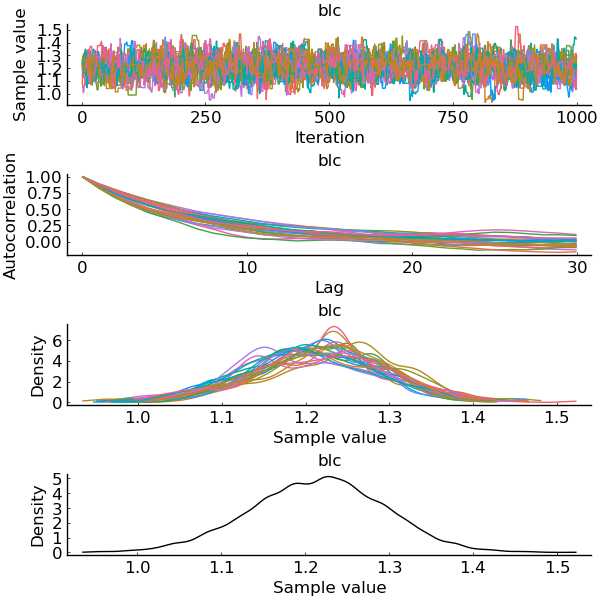

In [9]:
pyplot()
ch = group(chain, :blc)
font_size = 12
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
p4 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:pooleddensity),
  grid=false, size=(250,100), titlefont=font(font_size), color=:black)
pcblc = plot(p1, p2, p3, p4, layout=(4,1), size=(600,600))

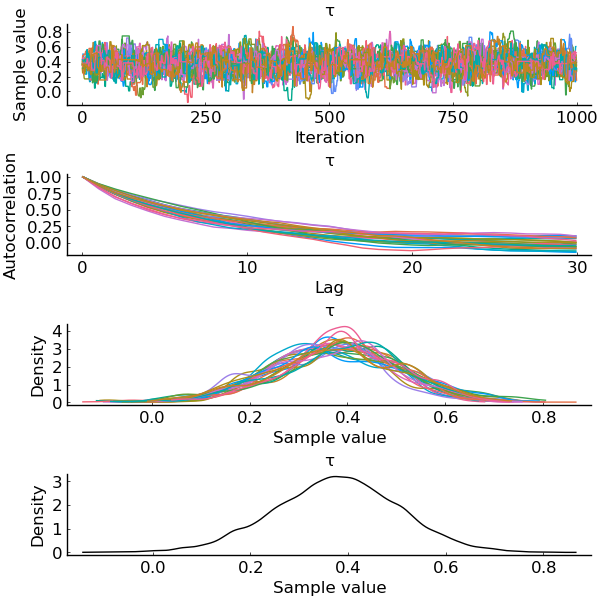

In [10]:
ch = group(chain, :τ)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
p4 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:pooleddensity),
  grid=false, size=(250,100), titlefont=font(font_size), color=:black)
pcτ = plot(p1, p2, p3, p4, layout=(4,1), size=(600,600))

### Posterior Predictive Distribution

The code block below plots the posterior predictive distributions for correct rts and incorrect rts. As expected, the density for incorrect rts is lower than correct rts, which reflects the fact that incorrect responses are less probable.  

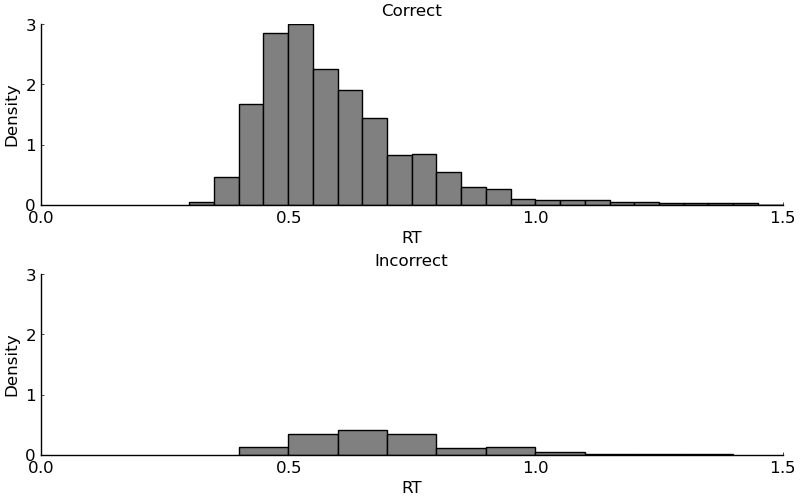

In [11]:
preds = posterior_predictive(x -> simulate(parms; x...), chain, 1000)
correct = filter(x-> x.resp == 1, preds)
rts = map(x->x.rt, correct)
p_correct = mean(x->x.resp == 1, preds)
correct_dist = histogram(rts, xlabel="RT", ylabel="Density", xaxis=font(font_size), yaxis=font(font_size),
    grid=false, norm=true, color=:grey, leg=false, size=(600,300), title="Correct", titlefont=font(font_size),
    xlims=(0,1.5))
correct_dist[1][1][:y] *= p_correct

incorrect = filter(x-> x.resp == 2, preds)
rts = map(x->x.rt, incorrect)
incorrect_dist = histogram(rts, xlabel="RT", ylabel="Density", xaxis=font(font_size), yaxis=font(font_size),
    grid=false, norm=true, color=:grey, leg=false, size=(600,300), title="Incorrect", titlefont=font(font_size),
    xlims=(0,1.5))
incorrect_dist[1][1][:y] *= (1 - p_correct)
plot(correct_dist, incorrect_dist, layout=(2,1), ylims=(0,3), size=(800, 500))